In [1]:
# Uncomment these to install required packages
# activate virtual environment
# !source .venv/bin/activate
# # install necessary packages
# !pip install pandas numpy sweetviz ipaddress python-dotenv scapy scipy summarytools xgboost matplotlib seaborn skimpy pandasai scikit-learn scikit-llm
# # alternatively you may use the requirements.txt
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import sweetviz as sv
import ipaddress
import os
import seaborn as sns

from dotenv import load_dotenv
from scapy.all import PcapReader, IP, TCP, UDP, ICMP
from scipy.stats import ttest_ind, zscore
from summarytools import dfSummary
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from pandasai import clear_cache

# scikit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier

# scikit llm imports
from skllm.config import SKLLMConfig
from skllm import (
    ZeroShotGPTClassifier,
    FewShotGPTClassifier,
    DynamicFewShotGPTClassifier,
)

In [3]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [4]:
# If this is set to true, we use old data and pickle files that have been created
READ_FROM_PICKLE = True

In [5]:
# read packet captures
pcap_reader_mirai = PcapReader("data/mirai.pcap")
pcap_reader_benign = PcapReader("data/benign.pcapng")

# Preprocess

Preprocessing includes cleaning up data and converting it to a usable format. In this example we:

- convert packet capture to Pandas DataFrame
- extract packet streams

In [6]:
def pcap_to_dataframe(pcap_reader: PcapReader) -> pd.DataFrame:
    """Converts a packet capture to a Pandas DataFrame.

    Args:
        pcap_reader (PcapReader): packet capture read using scapy

    Returns:
        pd.DataFrame: dataframe with pcap data
    """
    # Create an empty list to store the data
    data = []

    # Iterate through the packets in the pcap file
    for packet in pcap_reader:
        # Get the source and destination IP addresses
        if packet.haslayer(IP):
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
        else:
            src_ip = None
            dst_ip = None

            protocol = None

        # Get the source and destination ports and payload
        if packet.haslayer(TCP):
            src_port = packet[TCP].sport
            dst_port = packet[TCP].dport
            payload = str(packet[TCP].payload)
            packet_len = len(packet[TCP])
        elif packet.haslayer(UDP):
            src_port = packet[UDP].sport
            dst_port = packet[UDP].dport
            payload = str(packet[UDP].payload)
            packet_len = len(packet[UDP])
        elif packet.haslayer(ICMP):
            payload = str(packet[ICMP].payload)
            packet_len = len(packet[ICMP])
            src_port = None
            dst_port = None
        else:
            src_port = None
            dst_port = None
            payload = str(packet.payload)
            packet_len = len(packet)

        # Append the data to the list
        data.append(
            [
                packet.time,
                src_ip,
                dst_ip,
                src_port,
                dst_port,
                payload,
                packet_len,
                protocol,
            ]
        )

    # Convert the list to a pandas dataframe
    df = pd.DataFrame(
        data,
        columns=[
            "Timestamp",
            "Source IP",
            "Destination IP",
            "Source Port",
            "Destination Port",
            "Payload",
            "Packet Length",
            "Protocol",
        ],
    )

    return df

In [7]:
if not READ_FROM_PICKLE:
    mirai_df = pcap_to_dataframe(pcap_reader_mirai)
    benign_df = pcap_to_dataframe(pcap_reader_benign)

    mirai_df.to_pickle("data/mirai.pkl")
    benign_df.to_pickle("data/benign.pkl")

In [8]:
if READ_FROM_PICKLE:
    mirai_df = pd.read_pickle("data/mirai.pkl")
    benign_df = pd.read_pickle("data/benign.pkl")

In [9]:
mirai_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0
2,1540446382.934426,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1.0
3,1540446382.934636,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1.0
4,1540446383.291054,None,None,NaN,NaN,ARP who has 192.168.2.106 says 192.168.2.109 /...,60,NaN
...,...,...,...,...,...,...,...,...
764132,1540453519.837515,None,None,NaN,NaN,ARP who has 192.168.2.165 says 192.168.2.110 /...,60,NaN
764133,1540453519.839396,None,None,NaN,NaN,ARP who has 192.168.2.166 says 192.168.2.110 /...,60,NaN
764134,1540453519.840611,None,None,NaN,NaN,ARP who has 192.168.2.167 says 192.168.2.110 /...,60,NaN
764135,1540453519.842369,None,None,NaN,NaN,ARP who has 192.168.2.168 says 192.168.2.110 /...,60,NaN


In [10]:
benign_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,1241422456.122475,None,None,NaN,NaN,Raw,60,NaN
1,1241422456.122475,None,None,NaN,NaN,Raw,60,NaN
2,1241422758.60905,None,None,NaN,NaN,Raw,60,NaN
3,1241422758.60905,None,None,NaN,NaN,Raw,60,NaN
4,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0
...,...,...,...,...,...,...,...,...
38637,1671112304.885062,None,None,1812.0,43398.0,Radius,502,NaN
38638,1671112304.921208,None,None,43398.0,1812.0,Radius,225,NaN
38639,1671112304.926982,None,None,1812.0,43398.0,Radius,127,NaN
38640,1671112304.950305,None,None,43398.0,1812.0,Radius,180,NaN


## AI
Use pandas AI to clean up the data instead of using complicated functions to find duplicates and redundant records.

In [11]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)

In [12]:
mirai_smart = SmartDataframe(df=pd.DataFrame(mirai_df), config={"llm": llm})
mirai_cleaned_df = mirai_smart.clean_data()

In [13]:
benign_smart = SmartDataframe(df=pd.DataFrame(benign_df), config={"llm": llm})
benign_cleaned_df = benign_smart.clean_data()

In [14]:
if not READ_FROM_PICKLE:
    mirai_cleaned_df.to_pickle("data/mirai_cleaned.pkl")
    benign_cleaned_df.to_pickle("data/benign_cleaned.pkl")

In [15]:
if READ_FROM_PICKLE:
    mirai_cleaned_df = pd.read_pickle("data/mirai_cleaned.pkl")
    benign_clean_df = pd.read_pickle("data/benign_cleaned.pkl")

In [16]:
mirai_df.shape

(764137, 8)

In [17]:
mirai_cleaned_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
0,1540446382,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6
1,1540446382,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6
2,1540446382,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1
3,1540446382,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1
5,1540446383,192.168.2.101,192.168.2.110,NaN,NaN,Raw,40,1
...,...,...,...,...,...,...,...,...
764123,1540453519,192.168.2.1,192.168.2.109,NaN,NaN,"IPerror / UDPerror / DNS Qry ""b'time.windows.c...",70,1
764124,1540453519,192.168.2.108,52.24.43.67,47157.0,80.0,Padding,26,6
764125,1540453519,192.168.2.108,52.25.66.250,46453.0,8280.0,Padding,26,6
764126,1540453519,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1


In [18]:
benign_df.shape

(38642, 8)

In [19]:
benign_clean_df

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
4,1355253962,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17
5,1355253962,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17
6,1355253962,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17
7,1355253962,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17
24,1355253966,10.0.0.2,224.0.0.5,NaN,NaN,10.0.0.2 > 224.0.0.5 ospf / Raw,94,89
...,...,...,...,...,...,...,...,...
38585,1671035938,194.247.5.27,194.247.5.1,1812.0,10048.0,Radius,40,17
38586,1671035948,194.247.5.1,194.247.5.27,3860.0,1812.0,Radius,112,17
38587,1671035948,194.247.5.27,194.247.5.1,1812.0,3860.0,Radius,104,17
38588,1671035961,194.247.5.1,194.247.5.27,3373.0,1812.0,Radius,120,17


## Extract Streams

- Packet captures may be processed as individual packets or streams
- Streams are defined by the following tuple `(source IP, source port, destination IP, destination port, protocol)`
- We include numeric features:
  - total packet length
  - total number of packets
  - duration of stream

In [20]:
def extract_streams(df: pd.DataFrame) -> pd.DataFrame:
    # Create an empty list to store stream data as separate dataframes
    dfs = []

    # Group packets by src/dst IP and src/dst port
    grouped = df.groupby(
        ["Source IP", "Destination IP", "Source Port", "Destination Port", "Protocol"]
    )

    # Iterate through each group to extract stream data
    for name, group in grouped:
        # Get source/destination IP, port, and protocol
        src_ip, dst_ip, src_port, dst_port, proto = name

        # Get number of packets, total length, and duration of the stream
        num_packets = len(group)
        total_length = group["Packet Length"].sum()
        start_time = group["Timestamp"].min()
        end_time = group["Timestamp"].max()
        duration = float(end_time - start_time)

        # Create a new dataframe with the stream data
        stream_df = pd.DataFrame(
            {
                "Source IP": [src_ip],
                "Destination IP": [dst_ip],
                "Source Port": [src_port],
                "Destination Port": [dst_port],
                "Protocol": [proto],
                "Number of Packets": [num_packets],
                "Total Length": [total_length],
                "Duration": [duration],
            }
        )

        # Add the new dataframe to the list
        dfs.append(stream_df)

    # Concatenate all the dataframes in the list into one dataframe
    stream_df = pd.concat(dfs, ignore_index=True)

    # Return the new dataframe with stream data
    return stream_df

In [21]:
if not READ_FROM_PICKLE:
    mirai_stream_df = extract_streams(mirai_df)
    benign_stream_df = extract_streams(benign_df)

    mirai_stream_df.to_pickle("data/mirai_stream.pkl")
    benign_stream_df.to_pickle("data/benign_stream.pkl")

In [22]:
if READ_FROM_PICKLE:
    mirai_stream_df = pd.read_pickle("data/mirai_stream.pkl")
    benign_stream_df = pd.read_pickle("data/benign_stream.pkl")

### Note

The rest of the analysis revolves around stream data because of the size/time limitation for a real time demo.

In [23]:
# describe, summarize etc.
mirai_stream_df.columns

Index(['Source IP', 'Destination IP', 'Source Port', 'Destination Port',
       'Protocol', 'Number of Packets', 'Total Length', 'Duration'],
      dtype='object')

In [24]:
mirai_stream_df.dtypes

Source IP             object
Destination IP        object
Source Port          float64
Destination Port     float64
Protocol             float64
Number of Packets      int64
Total Length           int64
Duration             float64
dtype: object

# Feature Engineering

After exploring the data types, we start with the simplest feature engineering processing: convert IP addresses to numbers while maintaining the context.

## Numerical

In [25]:
# convert ip address to numeric values
def ip_to_numeric(ip):
    ip_obj = ipaddress.ip_interface(ip)
    return int(ip_obj.network.network_address)

In [26]:
# convert IPs to numeric mirai data
mirai_stream_df["Source IP Numeric"] = mirai_stream_df["Source IP"].apply(ip_to_numeric)
mirai_stream_df["Destination IP Numeric"] = mirai_stream_df["Destination IP"].apply(
    ip_to_numeric
)

In [27]:
# convert IPs to numeric benign data
benign_stream_df["Source IP Numeric"] = benign_stream_df["Source IP"].apply(
    ip_to_numeric
)
benign_stream_df["Destination IP Numeric"] = benign_stream_df["Destination IP"].apply(
    ip_to_numeric
)

In [28]:
# get rid of non numeric columns for IPs
mirai_stream_df_numeric = mirai_stream_df.drop(columns=["Source IP", "Destination IP"])
benign_stream_df_numeric = benign_stream_df.drop(
    columns=["Source IP", "Destination IP"]
)

In [29]:
# convert duration from object to float
mirai_stream_df["Duration"] = mirai_stream_df_numeric["Duration"].astype(float)
benign_stream_df["Duration"] = benign_stream_df_numeric["Duration"].astype(float)

In [30]:
# check if all data types are numeric now
mirai_stream_df_numeric.dtypes

Source Port               float64
Destination Port          float64
Protocol                  float64
Number of Packets           int64
Total Length                int64
Duration                  float64
Source IP Numeric           int64
Destination IP Numeric      int64
dtype: object

# EDA

Exploratory Data Analysis approaches the dataset as a black box that we need to visualize and analyze statistically with the following goals:
- get insights about our data
- test hypotheses
- decide on models and further processing, such as feature engineering.

EDA can be performed for benign and malicious data. Here we are looking at EDA only for malicious data, however the same functions can be applied to benign.

## Descriptive statistics & data

- Describe columns and data types
- Descriptive statistics
  -  count, 
  -  mean, 
  -  standard deviation, 
  -  minimum, 
  -  25th percentile, 
  -  median (50th percentile), 
  -  75th percentile, and 
  -  maximum

In [31]:
mirai_stream_df_numeric.describe()

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration,Source IP Numeric,Destination IP Numeric
count,14138.000000,14138.000000,14138.000000,14138.000000,14138.000000,14138.000000,1.413800e+04,1.413800e+04
mean,32980.104895,2152.375088,13.219479,4.705687,199.615009,14.185579,3.232008e+09,2.213406e+09
std,21650.445270,6092.466512,5.224492,72.311029,3057.301765,153.306208,2.718373e+07,1.137749e+09
min,0.000000,23.000000,6.000000,1.000000,26.000000,0.000000,0.000000e+00,1.347441e+08
25%,3206.250000,53.000000,6.000000,1.000000,40.000000,0.000000,3.232236e+09,1.035741e+09
50%,40048.500000,53.000000,17.000000,1.000000,74.000000,0.000000,3.232236e+09,2.063133e+09
75%,51555.000000,443.000000,17.000000,3.000000,104.000000,2.850280,3.232236e+09,3.232236e+09
max,64633.000000,63749.000000,17.000000,2862.000000,135840.000000,2571.501515,3.232236e+09,4.294967e+09


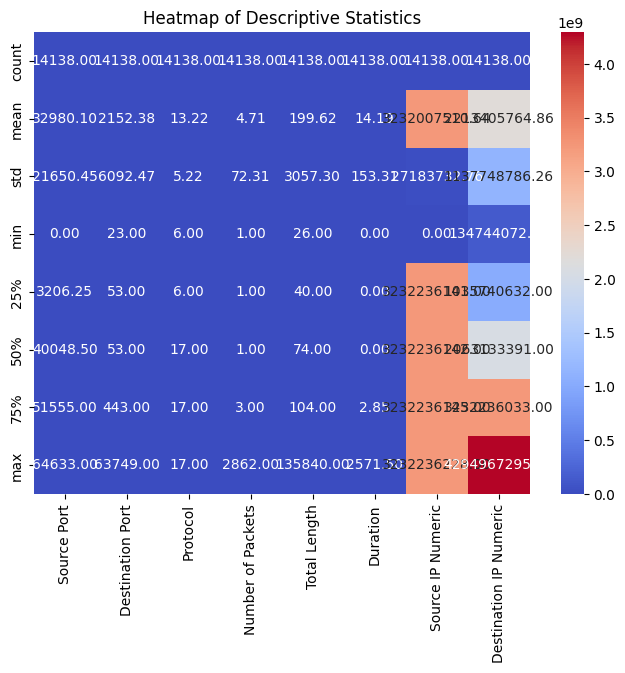

In [32]:
# Create a heatmap of descriptive statistics
plt.figure(figsize=(8, 6))
sns.heatmap(mirai_stream_df_numeric.describe(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Descriptive Statistics")
plt.show()

In [33]:
benign_stream_df_numeric.describe()

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration,Source IP Numeric,Destination IP Numeric
count,1689.000000,1689.000000,1689.000000,1689.000000,1.689000e+03,1.689000e+03,1.689000e+03,1.689000e+03
mean,26659.722321,20701.518058,15.106572,11.021314,3.281091e+03,1.049817e+05,2.407295e+09,2.296692e+09
std,24067.470929,23371.995707,6.130629,105.423967,6.560099e+04,4.298962e+06,1.269952e+09,1.360119e+09
min,7.000000,7.000000,6.000000,1.000000,2.600000e+01,0.000000e+00,0.000000e+00,1.684301e+07
25%,53.000000,53.000000,17.000000,1.000000,6.000000e+01,0.000000e+00,1.440178e+09,1.123634e+09
50%,34492.000000,3385.000000,17.000000,1.000000,1.300000e+02,0.000000e+00,3.232236e+09,3.232236e+09
75%,49872.000000,43346.000000,17.000000,5.000000,4.840000e+02,2.711000e-03,3.232266e+09,3.232267e+09
max,65535.000000,65535.000000,47.000000,3368.000000,2.643858e+06,1.766763e+08,3.640661e+09,4.294967e+09


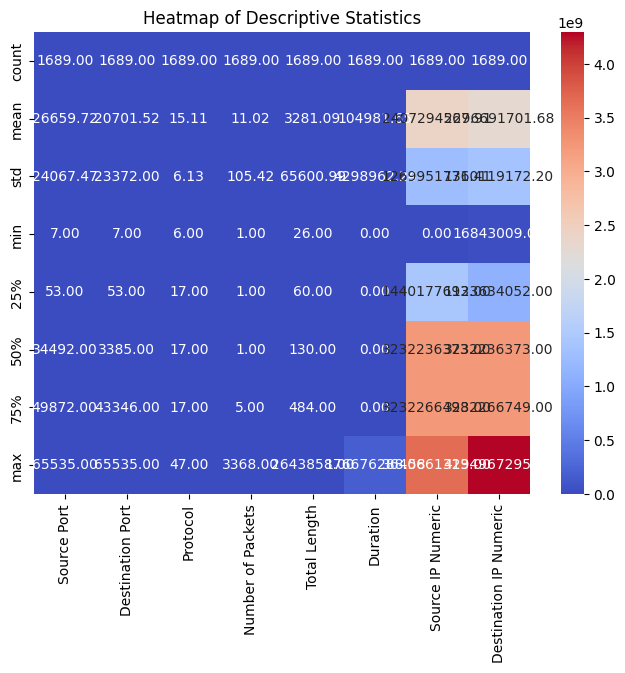

In [34]:
# Create a heatmap of descriptive statistics
plt.figure(figsize=(8, 6))
sns.heatmap(benign_stream_df_numeric.describe(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Descriptive Statistics")
plt.show()

In [35]:
mirai_correlation_matrix = mirai_stream_df_numeric.corr()
mirai_correlation_matrix

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration,Source IP Numeric,Destination IP Numeric
Source Port,1.000000,-0.135555,-0.311714,-0.013628,-0.012811,-0.016093,0.012786,-0.421899
Destination Port,-0.135555,1.000000,-0.214269,0.057033,0.057138,0.063952,0.002879,-0.104495
Protocol,-0.311714,-0.214269,1.000000,-0.013221,0.005097,0.005727,-0.006086,0.521454
Number of Packets,-0.013628,0.057033,-0.013221,1.000000,0.959277,0.620179,0.000315,-0.002053
Total Length,-0.012811,0.057138,0.005097,0.959277,1.000000,0.603591,-0.000364,-0.001499
Duration,-0.016093,0.063952,0.005727,0.620179,0.603591,1.000000,0.000762,-0.004545
Source IP Numeric,0.012786,0.002879,-0.006086,0.000315,-0.000364,0.000762,1.000000,-0.015388
Destination IP Numeric,-0.421899,-0.104495,0.521454,-0.002053,-0.001499,-0.004545,-0.015388,1.000000


In [36]:
benign_correlation_matrix = benign_stream_df_numeric.corr()
benign_correlation_matrix

,Source Port,Destination Port,Protocol,Number of Packets,Total Length,Duration,Source IP Numeric,Destination IP Numeric
Source Port,1.000000,-0.638892,0.027095,-0.002432,0.028749,-0.026975,0.463187,-0.418733
Destination Port,-0.638892,1.000000,-0.075318,-0.036162,-0.023302,-0.021550,-0.511441,0.263408
Protocol,0.027095,-0.075318,1.000000,0.007138,0.001792,0.007546,-0.026263,-0.053062
Number of Packets,-0.002432,-0.036162,0.007138,1.000000,0.875015,-0.000466,0.021948,0.035206
Total Length,0.028749,-0.023302,0.001792,0.875015,1.000000,-0.000119,0.014161,0.023329
Duration,-0.026975,-0.021550,0.007546,-0.000466,-0.000119,1.000000,-0.046140,0.035789
Source IP Numeric,0.463187,-0.511441,-0.026263,0.021948,0.014161,-0.046140,1.000000,-0.152641
Destination IP Numeric,-0.418733,0.263408,-0.053062,0.035206,0.023329,0.035789,-0.152641,1.000000


In [37]:
# Create a heatmap
def correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.set(font_scale=1.2)  # Adjust the font size as needed

    # Customize the heatmap
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        square=True,
        xticklabels=[
            "Source Port",
            "Destination Port",
            "Protocol",
            "Number of Packets",
            "Total Length",
            "Duration",
            "Source IP Numeric",
            "Destination IP Numeric",
        ],
        yticklabels=[
            "Source Port",
            "Destination Port",
            "Protocol",
            "Number of Packets",
            "Total Length",
            "Duration",
            "Source IP Numeric",
            "Destination IP Numeric",
        ],
    )

    plt.title("Correlation Heatmap")
    plt.show()

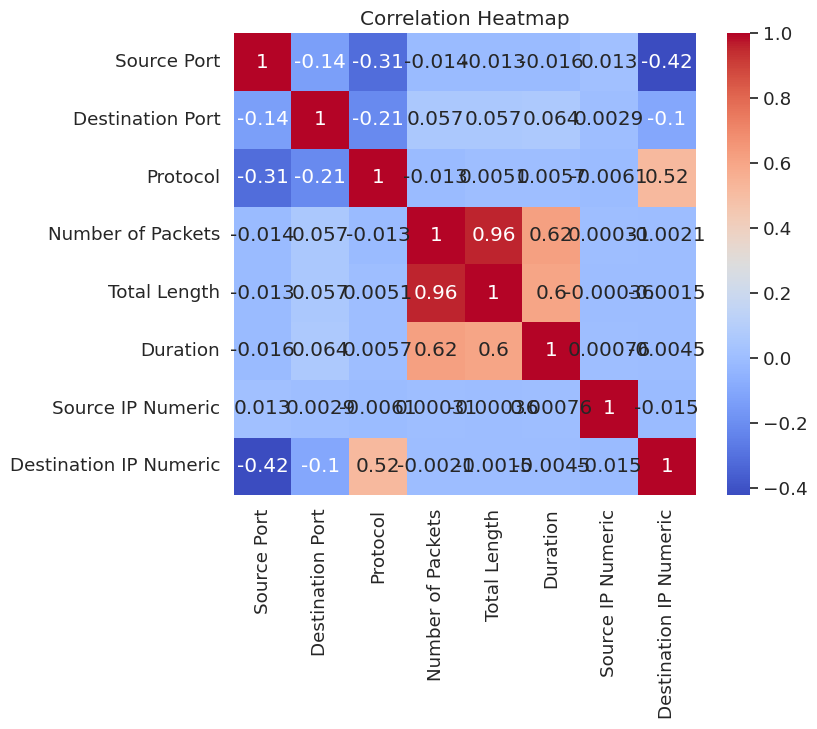

In [38]:
correlation_heatmap(mirai_correlation_matrix)

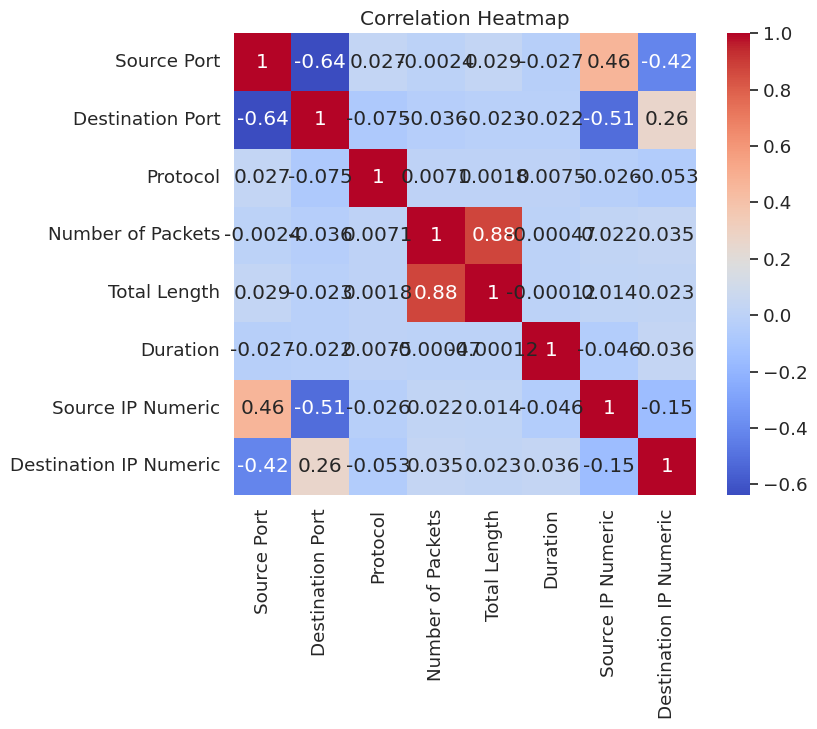

In [39]:
correlation_heatmap(benign_correlation_matrix)

## Hypothesis testing

- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [40]:
def hypothesis_testing(df, col1, col2):
    group1 = df[col1]
    group2 = df[col2]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between {} and {} is statistically significant (p < 0.05)".format(
            col1, col2
        )
    else:
        return "The difference between {} and {} is not statistically significant (p >= 0.05)".format(
            col1, col2
        )

In [41]:
hypothesis_testing(mirai_stream_df, "Number of Packets", "Total Length")

'The difference between Number of Packets and Total Length is statistically significant (p < 0.05)'

In [42]:
hypothesis_testing(benign_stream_df, "Number of Packets", "Total Length")

'The difference between Number of Packets and Total Length is statistically significant (p < 0.05)'

## Outliers

- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [43]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [44]:
outliers = detect_outliers_zscore(mirai_stream_df, "Total Length", threshold=3)
print(outliers)

           Source IP   Destination IP  Source Port  Destination Port  \
1        192.168.2.1    192.168.2.110         23.0           21897.0   
1611     192.168.2.1  239.255.255.250       1900.0            1900.0   
1613   192.168.2.101    192.168.2.110         23.0           21897.0   
1624   192.168.2.103    192.168.2.110         23.0           21897.0   
2083   192.168.2.107    192.168.2.110         23.0           21897.0   
2087   192.168.2.108   122.226.84.253      32761.0           10240.0   
2088   192.168.2.108  122.248.234.207      32761.0           10240.0   
2089   192.168.2.108    46.137.188.54      32761.0           10240.0   
2090   192.168.2.108    50.19.254.134      32761.0           10240.0   
3225   192.168.2.108    61.188.37.216      32761.0           10240.0   
6219   192.168.2.110      192.168.2.1      21897.0              23.0   
6884   192.168.2.110    192.168.2.101      21897.0              23.0   
6887   192.168.2.110    192.168.2.103      21897.0              

In [45]:
outliers = detect_outliers_zscore(benign_stream_df, "Total Length", threshold=3)
print(outliers)

           Source IP  Destination IP  Source Port  Destination Port  Protocol  \
851     192.168.7.26    192.168.7.12      61863.0            1303.0      17.0   
1267     217.0.5.215  84.146.135.221      15020.0            7078.0      17.0   
1330  84.146.135.221     217.0.5.215       7078.0           15020.0      17.0   

      Number of Packets  Total Length   Duration  Source IP Numeric  \
851                3368       2643858  26.629216         3232237338   
1267               1276        229680  25.541336         3640657367   
1330               1286        231480  25.700133         1418889181   

      Destination IP Numeric  
851               3232237324  
1267              1418889181  
1330              3640657367  


In [46]:
# TODO: plot outliers
# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# # Create a box plot with regular values
# sns.boxplot(data=benign_stream_df, x='Duration', y='Total Length', color='lightblue', label='Regular Values')

# # Overlay the outlier points on the same plot
# sns.scatterplot(data=outliers, x='Duration', y='Total Length', color='red', marker='X', label='Outliers')

# plt.title('Box Plot with Outliers')
# plt.xlabel('Duration')
# plt.ylabel('Total Length')
# plt.legend()
# plt.show()

## AI
Explore the data with AI. Use descriptive prompts instead of mathematical functions.

In [47]:
top_5_source_IPs = mirai_smart.chat("Which are the 5 most popular source IP addresses?")

top_5_source_IPs

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'OpenAI' object has no attribute 'api_base'\n"

In [48]:
top_5_dst_ports = mirai_smart.chat("Which are the 5 most popular destination ports?")
top_5_dst_ports

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'OpenAI' object has no attribute 'api_base'\n"

In [49]:
rare_ports = benign_smart.chat(
    "Which are the most rarely used ports within the range of 0-1024?"
)
rare_ports

,Port,Count
0,69.0,1


In [50]:
mirai_smart_stream = SmartDataframe(mirai_stream_df, config={"llm": llm})
benign_smart_stream = SmartDataframe(benign_stream_df, config={"llm": llm})

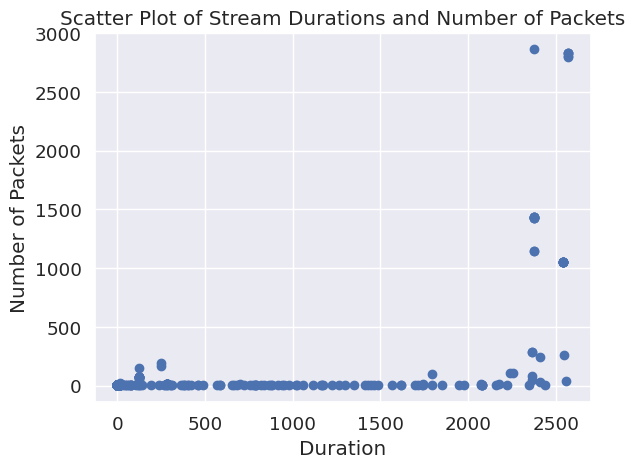

In [51]:
mirai_smart_stream.chat("Plot the scatter plot of stream durations and number of packets.")

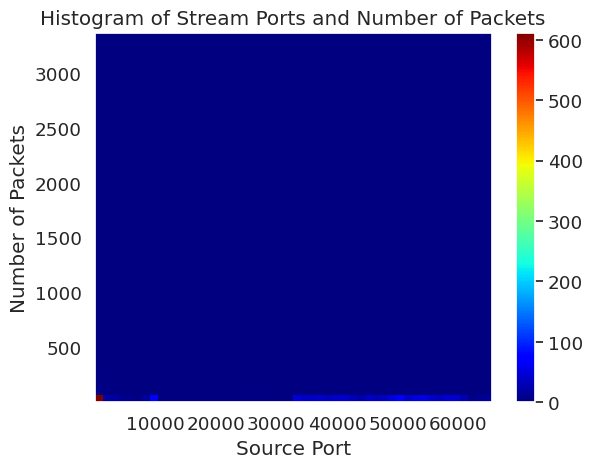

In [52]:
benign_smart_stream.chat("Plot the histogram stream ports and number of packets.")

# Summaries & Visualizations
Using packages `skim`, `dfSummary`, and `sweetviz`, we create a wealth of visualizations with minimal code. These visualizations offer valuable insights for data exploration.

In [53]:
skim(mirai_stream_df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14138  │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃    ┃      ┃            ┃            ┃           ┃           ┃            ┃           ┃        ┃  │
│ ┃ e          ┃ NA ┃ NA % ┃ mean       ┃ sd         ┃ p0        ┃ p25       ┃ p75        ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Source     │  0 │    0 │      33000 │      22000 │         0 │      3200 │      52000 │     65000 │ █▁▁▇▇▅ │  │
│ │ Port       │    │      │            │            │           │           │            │           │        │  │
│ │ Destinatio │  0 │    0 │       2200 │       6100 │        23 │        53 │        440 │     64000 │   █    │  │
│ │ n Port     │    │      │            │            │           │           │            │           │        │  │
│ │ Protocol   │  0 │    0 │         13 │        5.2 │         6 │         6 │         17 │        17 │ ▄    █ │  │
│ │ Number of  │  0 │    0 │        4.7 │         72 │         1 │         1 │          3 │      2900 │   █    │  │
│ │ Packets    │    │      │            │            │           │           │            │           │        │  │
│ │ Total      │  0 │    0 │        200 │       3100 │        26 │        40 │        100 │    140000 │   █    │  │
│ │ Length     │    │      │            │            │           │           │            │           │        │  │
│ │ Duration   │  0 │    0 │         14 │        150 │         0 │         0 │        2.9 │      2600 │   █    │  │
│ │ Source IP  │  0 │    0 │ 3200000000 │   27000000 │         0 │ 320000000 │ 3200000000 │ 320000000 │      █ │  │
│ │ Numeric    │    │      │            │            │           │         0 │            │         0 │        │  │
│ │ Destinatio │  0 │    0 │ 2200000000 │ 1100000000 │ 130000000 │ 100000000 │ 3200000000 │ 430000000 │ ▂▃▃ █  │  │
│ │ n IP Numer │    │      │            │            │           │         0 │            │         0 │        │  │
│ └────────────┴────┴──────┴────────────┴────────────┴───────────┴───────────┴────────────┴───────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [54]:
skim(benign_stream_df_numeric)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1689   │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃    ┃      ┃            ┃            ┃          ┃            ┃            ┃           ┃        ┃  │
│ ┃ e          ┃ NA ┃ NA % ┃ mean       ┃ sd         ┃ p0       ┃ p25        ┃ p75        ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Source     │  0 │    0 │      27000 │      24000 │        7 │         53 │      50000 │     66000 │ █  ▃▄▂ │  │
│ │ Port       │    │      │            │            │          │            │            │           │        │  │
│ │ Destinatio │  0 │    0 │      21000 │      23000 │        7 │         53 │      43000 │     66000 │ █  ▃▂▂ │  │
│ │ n Port     │    │      │            │            │          │            │            │           │        │  │
│ │ Protocol   │  0 │    0 │         15 │        6.1 │        6 │         17 │         17 │        47 │   ▂█   │  │
│ │ Number of  │  0 │    0 │         11 │        110 │        1 │          1 │          5 │      3400 │   █    │  │
│ │ Packets    │    │      │            │            │          │            │            │           │        │  │
│ │ Total      │  0 │    0 │       3300 │      66000 │       26 │         60 │        480 │   2600000 │   █    │  │
│ │ Length     │    │      │            │            │          │            │            │           │        │  │
│ │ Duration   │  0 │    0 │     100000 │    4300000 │        0 │          0 │     0.0027 │ 180000000 │   █    │  │
│ │ Source IP  │  0 │    0 │ 2400000000 │ 1300000000 │        0 │ 1400000000 │ 3200000000 │ 360000000 │ ▂ ▁  █ │  │
│ │ Numeric    │    │      │            │            │          │            │            │         0 │        │  │
│ │ Destinatio │  0 │    0 │ 2300000000 │ 1400000000 │ 17000000 │ 1100000000 │ 3200000000 │ 430000000 │ ▃▁  █  │  │
│ │ n IP Numer │    │      │            │            │          │            │            │         0 │        │  │
│ └────────────┴────┴──────┴────────────┴────────────┴──────────┴────────────┴────────────┴───────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [55]:
dfSummary(mirai_stream_df_numeric)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Source Port[float64],Mean (sd) : 32980.1 (21650.4)min < med < max:0.0 < 40048.5 < 64633.0IQR (CV) : 48348.8 (1.5),"10,709 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACgElEQVR4nO3cu47aQBSA4TOwoOEim1ugo0lBsVIKJBoeIGUeNo+QgiI1LUVEh7jICGcJxpAKKYmAxcPuwZD/a9EZufg1aNczmP1+L4CWp3MfGmMKIpJ3WHez3+9f3B4Jj+xkcMaYQr1e/+J5XjXposvlcmGM+Up0+Ne5HS7veV613++/+L6/vnTBIAjsYDCozmazvIgQHP5y9itVRMT3/XWz2fyZcN2C4/PgwWVu/QD4vxAcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVL16xBz3L0237wjuwaXt9h3BObpi1xDRvbebqtt3BOfgml1D5Db3dtNy+47g3DjtGiLX7RyOu6q32+1yCWfeDcFdwXHXkDiOPRHxjDFJxmytVvvs+34pyVAURTaO4+f1ev1NRBI/61sjOGVhGOaiKPrUbrez2Wz24t0xiiIrIs+9Xu97o9FYXjo3Ho+rw+GwuN1us04P/MYITtlms3my1ha73e661WotLp07hGOtjZLsqovFIlW/gkBwN1IqlRJ9HactHFe8aYAqgoMqgoMqgoMqgoMqgoMqgoMqgoMqgoMq3jTgpDiOc5L8kMHB0TN/BIejXA8ZHJw680dwOMr1kIHI+TN/BIezkh4y+MPRwwb80QBVBAdVBAdVBAdVBAdVBAdVBAdVBAdV7/KP3yvfwWVEZJfyuVTdZr8nbx7cNe/g4jjOhWH4sVwujzKZTJTWubTdZr8nrwYXBIFNsuB8Pi9ba4udTsdUKpVfSWan06kdjUYfOp3Oj0qlskr5XDEIgtJkMtlcOicislqtrIhIGIZ2MpkUH21O5HwzvwFBQUKp+czHIQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Destination Port[float64],Mean (sd) : 2152.4 (6092.5)min < med < max:23.0 < 53.0 < 63749.0IQR (CV) : 390.0 (0.4),"1,643 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABwElEQVR4nO3dsW7aUBiG4e8vBJlQ+QiQYOMSOjCyd+3Fdu3OxSChcBBOKMhypw5JVRJbyVfJfZ/VOkdH1itbZ/qjaRoBLsNbDyNiLGnUYd9L0zRP3Y6EPvtrcBExns/n38qynLbd9Hg8PkTEd6LDS7e+cKOyLKebzeYppXR+64Y552K73U73+/1IEsHhmZu/VElKKZ0Xi8Vjy33HHc+Dnvv0rw+A/wvBwYrgYEVwsCI4WBEcrAgOVgQHK4KDFcHBiuBgRXCwIjhYERysCA5WBAcrgoMVwcGK4GBFcLAiOFgRHKwIDlYEByuCgxXBwYrgYEVwsCI4WBEcrAgOVgQHK4KDFcHBiuBgRXCwIjhYERysCA5WBAcrgoMVwcGK4GBFcLB6dbhbF3Vd30kqI6LLcmat9ti7B1dV1d31ev2yWq0Gg8HgzWMvf2PWar+9e3CXy2VYFMX9er0+L5fLhzZrmbXafx/yS5WkyWTSZc6qxKzVXuPSAKsP+8K5RcRY0qjDUi4pRq8Gl3Mu2mx4Op0KSaqqqtjtdvdt1uaci7quh2p/wy1ms9nXlNLnNosk6XA4nCLih6TWFxzc9LNpmj/e6S+XWGqltUZuvAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Protocol[float64],1. 17.02. 6.0,"9,279 (65.6%)4,859 (34.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOklEQVR4nO3bMWrDQBRF0a8gTNzMIARajBaRxWYRsxshNEVs3EwKF8GkNW+cl3tW8I0vAhu9obUWgMIQEeeIOPU+BL/cWmuX3kc80zjP80dKaep9CB7VWvdhGD6dghtTStO6rpec87X3Mbg7juO9lDJt23aKCJ/YIiJyztdlWb56H4MH594HPNtb7wPwfxAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CAzRtxf1ut9CH64fh9jrXUvpUxh+LLeX1Zr3SPi1vuOZ2Lw8rrsBi8DUz6ouD7Z7J4KDiynfI4zOAd2Uz7XGZwD1ykfv6xfEH/qQobYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZuymf02dxYznlc5zBOWDwAplvCltq30b8rewAAAAASUVORK5CYII="">",0(0.0%)
4,Number of Packets[int64],Mean (sd) : 4.7 (72.3)min < med < max:1.0 < 1.0 < 2862.0IQR (CV) : 2.0 (0.1),39 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3dMWoCQRiG4Zkgos0uIngYD5HD5hDeRsJYRBOQSR0hGrf4QszzlDvw8xcvM+XW3nuBlNm1w1rrspQynzD3o/d+nLYSj+zb4Gqty/V6/TwMw+reoYfD4bXW+iI6Ll274ebDMKy22+1xHMfTTwe21ha73W613+/npRTB8cXVJ7WUUsZxPG02m7c75y4n7sODe/rtBfhfBEeU4IgSHFGCI0pwRAmOKMERJTiiBEeU4IgSHFGCI0pwRAmOKMERJTiiBEeU4IgSHFGCI0pwRAmOKMERJTiiBEeU4IgSHFGCI0pwRAmOKMERJTiiBEeU4IgSHFGCI0pwRAmOKMERJTiiBEeU4IgSHFGCI0pwRAmOKMERJTiiBEfUzV+Qt9YW9wxsrS3O5/OslDLUWicvxp/33ns/XX78BGFcLdZo2ltjAAAAAElFTkSuQmCC"">",0(0.0%)
5,Total Length[int64],Mean (sd) : 199.6 (3057.3)min < med < max:26.0 < 74.0 < 135840.0IQR (CV) : 64.0 (0.1),136 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJw

In [56]:
dfSummary(benign_stream_df_numeric)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Source Port[float64],Mean (sd) : 26659.7 (24067.5)min < med < max:7.0 < 34492.0 < 65535.0IQR (CV) : 49819.0 (1.1),960 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaUlEQVR4nO3cP2/aQBiA8fcKRAdUtjAINr5ApA5ILOzt2A/bj9CBITPfgA2BkBFOLIxxJ6S2CoQ78MufPL81OvuUPLr4DDpTFIUAWqrHfmiMqYvIk8d1N0VRvPlNCY/sYHDGmHq73f4ZBEHL9aKr1WppjPlFdPjfsRXuKQiC1mg0egvDMD31gnEc2/F43FosFk8iQnD4x9F/qSIiYRim3W731fG6dc/54MF9ufYE8LkQHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFQRHFR9eCAh7t8tndVMcHfEMxwbRdGPMAybrvcr46xmgvN0xqoh4rFy+B7ynWWZFZHn4XD40ul0VqeOK+usZoLzcM4J7yLeK4fXId/T6bQ1mUwa1trsFs5qJjg/Xn98kfNXDtdDvpfL5U0d8E1wZ/A84V3yPA9EJDDGuAwLdrtdzfVet4bglCVJUsuy7Fu/369UKpWTV8csy2ye589pmv4WEefIbwXBKdtsNlVrbWMwGKS9Xm956rj9s9h2u62UOb+yEdyVNJvNu34W88UnDVDFCoeD8jyvifvmZu/dd42lBFfGRKHLd3Ozd+hd48WDK2ui0OW7uRE5/q7x4sGVNVFch+vm5i/vbnJKe4a79ETxGNilQhXBQdWnfy3i+TWjh/hc8xo+DC6OY+tywfV6bUVEkiSxs9ms4TI2jmOb53lV/F+puLJRFH0Pw/Cry6D955rz+fzF9Ya+v597GSdyvJk/4kkr/f1YidgAAAAASUVORK5CYII="">",0(0.0%)
2,Destination Port[float64],Mean (sd) : 20701.5 (23372.0)min < med < max:7.0 < 3385.0 < 65535.0IQR (CV) : 43293.0 (0.9),741 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACTUlEQVR4nO3dy4riQBSA4VOjreWFBC/ozhdo6IXgJg8wy3nYeYRZuOi1b+BOkBAx3WKMmZXQM8zYVmlOe/m/bZN0KH4qMYLHFEUhgJbqsT8aYxoiUvM477Yoine/S8I9+29wxphGr9f7EQRBx/Wkq9UqNsb8JDr87dgOVwuCoBNF0XsYhptTT5gkiZ1Op53lclkTEYLDH47eUkVEwjDcDAaDN8fzNjyvB3fu21dfAB4LwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUEVwUHVp79ijn87Y2iKyAMPTiE4D+cMTRF57MEpBOfHa2iKCINTCO4MnkNTRJQHp1zTzDSCuyGe4dhut/s9DMOW6/8r49ZPcDfC97kxyzIrIs+TyeS13++vTj2urFs/wX2BPM+fRCQwxrgcFrTb7UEURSuX58b5fN6ZzWZNa212DTPTSgnOc0EP7vqVQZqmT1mWvYxGo0qlUjk5nCzLbJ7nz/V6/ZdLOHEcX9WgvYsH57ugB/f+ymC73Vattc3xeLwZDofxqccddqrdblcp8/o+KmPjuHhwvgsq8livDFqtltMnXO2dqqyNo7RnONcF/eCqbgGPqqyNgw8NOOrSGwdf3kPVpztckiTW5YTr9dqKiKRpaheLRdPl2CRJbJ7nVfF/UNUS7Pf7quvaiPivz60cJ3K8md/tYhxh9Y4OzAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Protocol[float64],1. 17.02. 6.03. 41.04. 47.0,"1,272 (75.3%)378 (22.4%)35 (2.1%)4 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACBklEQVR4nO3bQW7TUBSG0esoKnTiKIrUJcAevAgWyyKyCPYQRfGAlE7MoAVBxATh/H4y58wyu1I+2XnRu900TQUJm6UH4P8hNmK6qnqsqoelB2FWL9M0XZce4tb2cDh86vt+v/QgzGccx3PXdZ9bC27b9/1+GIbrbrd7XnoY/t3lcnl/PB73p9Ppoaraiq2qarfbPT89PX1dehhm87j0AH/igECM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxGyrXq+lLD0I82j5u9yO43g+Ho/7avRaCn9vHMdzVb0sPcct18LXqclr4Z1VPlIcEIhp7TXa5OOfeTS1XdXqVhDzaGa7quWtIObR2naVv19WzAGBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzHNrPK1MAP31dQqX6sraMzDDgIxVvmIuX2yebJwN79tV9lu4p42P7arhmG4vkXXyu83VubndtXb58VPpKyXP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEdPMdhXr9+t2le0m7soOAjG2q4hxQCBm03Xdx67rHBC4u01Vfaiqd0sPwvp5jRIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YTVV9qapvSw/C+ll4IcZrlBixEfMd6iScShhmFWYAAAAASUVORK5CYII="">",0(0.0%)
4,Number of Packets[int64],Mean (sd) : 11.0 (105.4)min < med < max:1.0 < 1.0 < 3368.0IQR (CV) : 4.0 (0.1),67 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3dMWoCQRiG4Zkgos0uIngYD5HD5hDeRsJYRBOQSR0hGrf4QszzlDvw8xcvM+XW3nuBlNm1w1rrspQynzD3o/d+nLYSj+zb4Gqty/V6/TwMw+reoYfD4bXW+iI6Ll274ebDMKy22+1xHMfTTwe21ha73W613+/npRTB8cXVJ7WUUsZxPG02m7c75y4n7s

In [57]:
my_report = sv.analyze(mirai_stream_df_numeric)
my_report.show_html(filepath="html/mirai_stream.html")

/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method

Report html/mirai_stream.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [58]:
my_report = sv.analyze(benign_stream_df_numeric)
my_report.show_html(filepath="html/benign_stream.html")

[1128/213852.855887:ERROR:file_io_posix.cc(152)] open /home/drx/.config/BraveSoftware/Brave-Browser/Crash Reports/pending/83df2ce0-9359-4e34-8a6c-58e503ea954c.lock: File exists (17)
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

Opening in existing browser session.


/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/home/drx/sandbox/bsides-augusta-2023/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method

Report html/benign_stream.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Labeling
We label and concatenate benign and malicious before one-hot because there are different ports in each dataset and concatenating the two after one hot will not work with different columns.

In [59]:
# add labels, 0 for benign, 1 for malicious
mirai_stream_df_numeric["Labels"] = 1
benign_stream_df_numeric["Labels"] = 0

[1128/213901.340848:ERROR:file_io_posix.cc(152)] open /home/drx/.config/BraveSoftware/Brave-Browser/Crash Reports/pending/83df2ce0-9359-4e34-8a6c-58e503ea954c.lock: File exists (17)


In [60]:
# concatenate dataframes
data_df = pd.concat(
    [mirai_stream_df_numeric, benign_stream_df_numeric], ignore_index=True
)

Opening in existing browser session.


# Feature engineering (cont.) categorical 
## One-hot
One-hot encoding transforms features to individual columns with binary values. For example, if there are 10 distinct ports in the dataset, 10 columns will be created and each packet will have a 0 if it does not use that port and 1 if it does in the corresponding column.

In [61]:
def one_hot_encode(df, feature):
    feature_dummies = pd.get_dummies(df[feature], prefix=feature)
    return pd.concat([df, feature_dummies], axis=1)

In [62]:
data_df = one_hot_encode(data_df, "Source Port")
data_df = one_hot_encode(data_df, "Destination Port")

## AI
Generate features using `generate_features` from `pandas_ai` on cleaned up data or subset of original due to long requests.

In [63]:
mirai_smart = SmartDataframe(df=pd.DataFrame(mirai_cleaned_df), config={"llm": llm})
mirai_smart_features = mirai_smart.generate_features()

In [64]:
benign_smart = SmartDataframe(df=pd.DataFrame(benign_df), config={"llm": llm})
benign_smart_features = benign_smart.generate_features()

In [65]:
mirai_cleaned_df.columns

Index(['Timestamp', 'Source IP', 'Destination IP', 'Source Port',
       'Destination Port', 'Payload', 'Packet Length', 'Protocol'],
      dtype='object')

In [66]:
mirai_smart_features

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,Source IP Length,Destination IP Length,Source Port Even/Odd,Destination Port Even/Odd
0,1540446382,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6,13,11,Even,Even
1,1540446382,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6,13,12,Even,Even
2,1540446382,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1,11,13,Odd,Odd
3,1540446382,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1,11,13,Odd,Odd
5,1540446383,192.168.2.101,192.168.2.110,NaN,NaN,Raw,40,1,13,13,Odd,Odd
...,...,...,...,...,...,...,...,...,...,...,...,...
764123,1540453519,192.168.2.1,192.168.2.109,NaN,NaN,"IPerror / UDPerror / DNS Qry ""b'time.windows.c...",70,1,11,13,Odd,Odd
764124,1540453519,192.168.2.108,52.24.43.67,47157.0,80.0,Padding,26,6,13,11,Odd,Even
764125,1540453519,192.168.2.108,52.25.66.250,46453.0,8280.0,Padding,26,6,13,12,Odd,Even
764126,1540453519,192.168.2.1,192.168.2.108,NaN,NaN,IPerror / TCPerror,52,1,11,13,Odd,Odd


In [67]:
mirai_smart_features.columns

Index(['Timestamp', 'Source IP', 'Destination IP', 'Source Port',
       'Destination Port', 'Payload', 'Packet Length', 'Protocol',
       'Source IP Length', 'Destination IP Length', 'Source Port Even/Odd',
       'Destination Port Even/Odd'],
      dtype='object')

In [68]:
benign_smart_features

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'OpenAI' object has no attribute 'api_base'\n"

# Model Training
- We use some characteristic models for demonstration purposes. Models need to be tuned by exploring their hyperparameters and compared in order to pick the best one for the application.
  - xgboost
  - NN
  - k-NN
  - Random Forest
- k-fold cross validation
  - split the data in k parts
  - use one part for testing, the other k-1 parts for training the model
  - repeat for all the combinations of k parts using a different one for testing, the other k-1 for training the model

In [69]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

In [70]:
# randomize the data. TODO: is this needed??
data_df = shuffle(data_df)

In [71]:
# after feature engineering, drop all the columns that are unnecessary
data_df = data_df.drop(["Source Port", "Destination Port"], axis=1)

In [72]:
# store the features and labels in separate dataframes
X = data_df.drop("Labels", axis=1)
y = data_df["Labels"]

In [73]:
# convert data to array
data_array = data_df.to_numpy()

In [74]:
# print splits for better understanding
model = 1
for train, test in kfold.split(data_array):
    print(f"Model {model}")
    print(f"train {train}, test: {test}")
    model += 1

Model 1
train [    0     1     2 ... 15824 15825 15826], test: [    4     5     6 ... 15815 15820 15823]
Model 2
train [    0     1     2 ... 15823 15824 15825], test: [    7    12    16 ... 15811 15817 15826]
Model 3
train [    0     2     4 ... 15824 15825 15826], test: [    1     3    10 ... 15812 15818 15821]
Model 4
train [    0     1     2 ... 15823 15824 15826], test: [    8     9    13 ... 15816 15822 15825]
Model 5
train [    1     3     4 ... 15823 15825 15826], test: [    0     2    15 ... 15806 15819 15824]


## Model selection

We picked three characteristic models:
- Decision Tree
- Random Forest
- XGB

In [75]:
decision_tree = DecisionTreeClassifier()

In [76]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=2, random_state=0)

In [77]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)

# Model Evaluation

## Metrics
We compare all models using the following metrics:
- accuracy: Accuracy is the proportion of correct predictions to the total number of predictions.
- precision: Precision measures the proportion of true positives to the total predicted positives.
- recall: Recall (also known as sensitivity or true positive rate) measures the proportion of true positives to the total actual positives.
- f1 score

Note: we use the models out of box without fine tuning them.

In [78]:
def k_fold_validation_metrics(model, k, X, y):
    # Initialize lists to store evaluation metrics for each fold
    precision_scores = []
    accuracy_scores = []
    recall_scores = []
    f1_scores = []

    # convert dataframes to numpy arrays
    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, y):
        # Split the data into train and test sets for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics for this fold
        precision = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Append the scores to the respective lists
        precision_scores.append(precision)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Calculate the average of the evaluation metrics over all folds
    avg_precision = np.mean(precision_scores)
    avg_accuracy = np.mean(accuracy_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return {
        "Average Precision": avg_precision,
        "Average Accuracy": avg_accuracy,
        "Average Recall": avg_recall,
        "Average F1-Score": avg_f1,
    }

In [79]:
dt_evaluation = k_fold_validation_metrics(decision_tree, k, X, y)
dt_evaluation

{'Average Precision': 0.9988694824444373,
 'Average Accuracy': 0.9986731853750204,
 'Average Recall': 0.9996463181615548,
 'Average F1-Score': 0.9992576568977845}

In [80]:
rf_evaluation = k_fold_validation_metrics(rf, k, X, y)
rf_evaluation

{'Average Precision': 0.89328363466891,
 'Average Accuracy': 0.89328363466891,
 'Average Recall': 1.0,
 'Average F1-Score': 0.9436342386903608}

In [81]:
xgb_evaluation = k_fold_validation_metrics(xgb, k, X, y)
xgb_evaluation

{'Average Precision': 0.998940278622074,
 'Average Accuracy': 0.9989259300286715,
 'Average Recall': 0.9998585322679017,
 'Average F1-Score': 0.9993991246144525}

## Confusion matrix

A confusion matrix is a table that visualizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X, y):
    # Initialize an empty confusion matrix
    cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

    # Perform k-fold cross-validation and accumulate the confusion matrix
    predictions = cross_val_predict(model, X, y, cv=5)  # Change cv value as needed
    cm += confusion_matrix(y, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

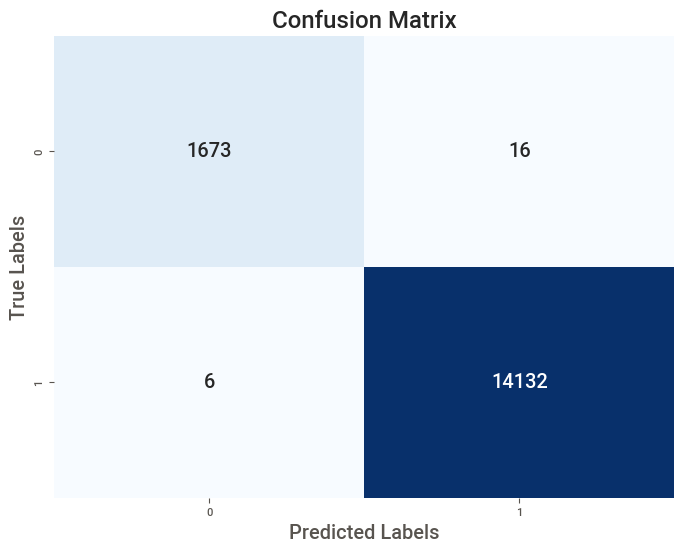

In [83]:
plot_confusion_matrix(decision_tree, X, y)

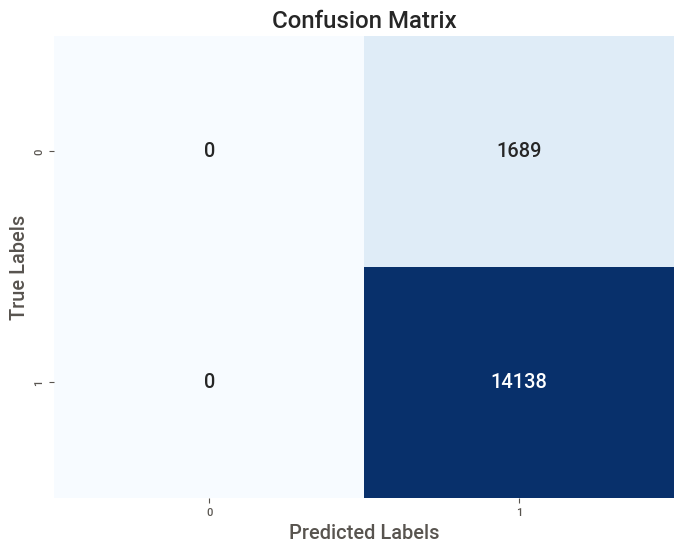

In [84]:
plot_confusion_matrix(rf, X, y)

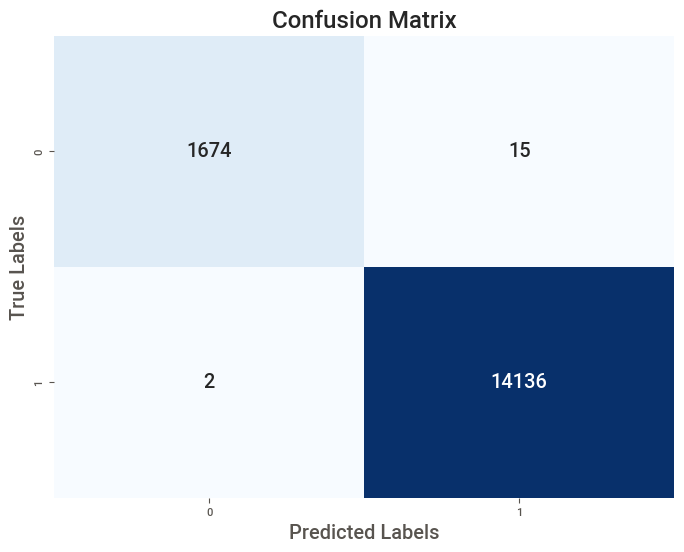

In [85]:
plot_confusion_matrix(xgb, X, y)

## ROC curve

Use a ROC curve to visualize the model evaluation:
- The X-axis indicates the False Positive Rate
- The Y-axis indicates the True Positive Rate
- The higher the area under the curve the better the model performance
- The diagonal line indicates the performance of a random classifier
- Performance at the top level corner indicates high TPR with low TPR for the same threshold

In [86]:
def plot_roc_curve(model, X, y, n_folds=5):
    # Initialize variables to store false positive rate and true positive rate for each fold
    mean_fpr = np.linspace(0, 1, 100)
    tpr_sum = 0

    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    plt.figure(figsize=(8, 6))

    for train, test in cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tpr_sum += np.interp(mean_fpr, fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    mean_tpr = tpr_sum / n_folds
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random Chance")
    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        lw=2,
        label="Mean ROC (AUC = {:.2f})".format(auc(mean_fpr, mean_tpr)),
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

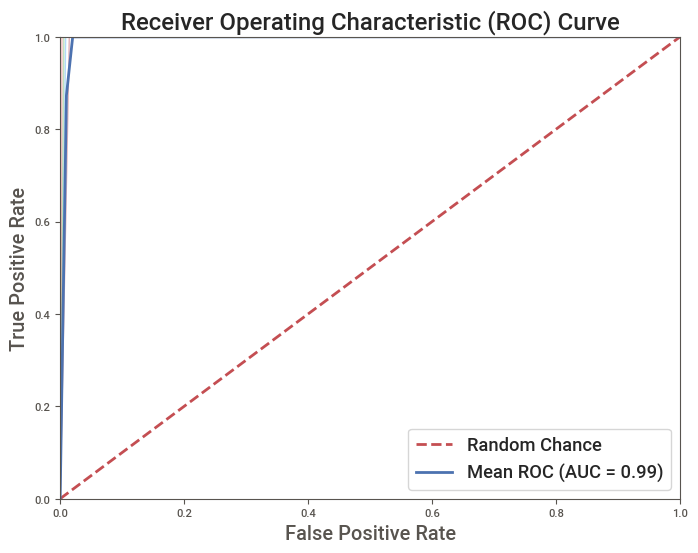

In [87]:
plot_roc_curve(decision_tree, X, y)

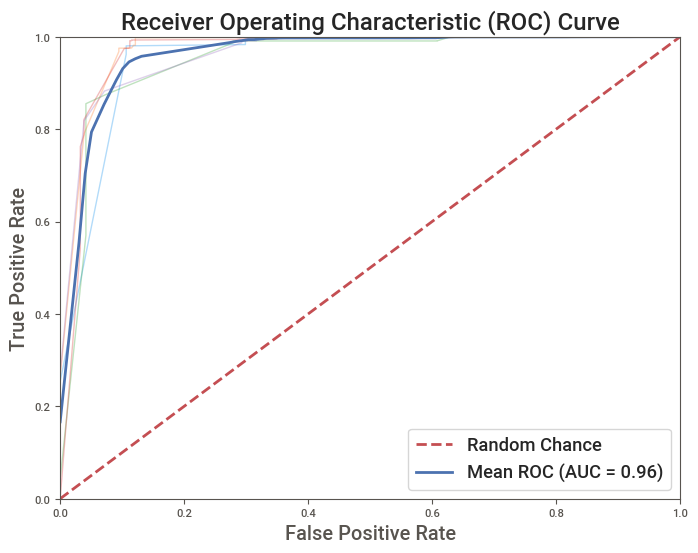

In [88]:
plot_roc_curve(rf, X, y)

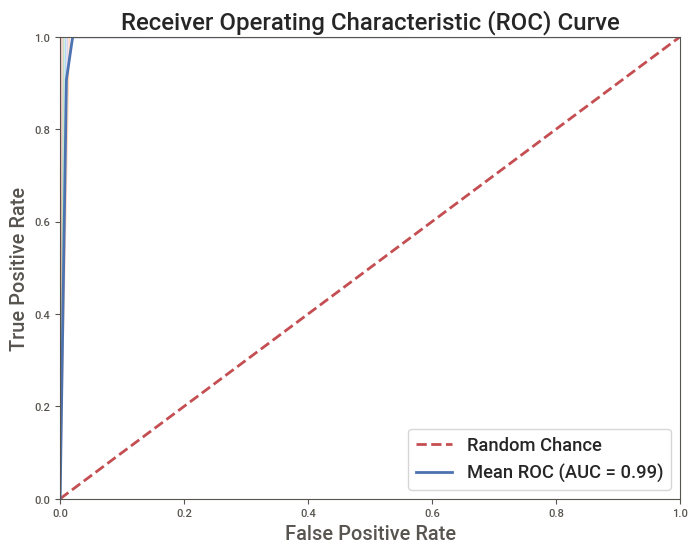

In [89]:
plot_roc_curve(xgb, X, y)

# AI Classifier 
Use llm for classification. Can only use payload that is words.

In [90]:
# add labels, 0 for benign, 1 for malicious
mirai_cleaned_df["Labels"] = 1
benign_clean_df["Labels"] = 0

In [91]:
mirai_payloads = mirai_cleaned_df[["Payload", "Labels"]]
benign_payloads = benign_clean_df[["Payload", "Labels"]]

In [92]:
payloads = pd.concat([mirai_payloads, benign_payloads], ignore_index=True)

In [93]:
# TODO: use sample
payloads = shuffle(payloads)

In [94]:
# use a subset because this takes loooong!
X_llm = payloads["Payload"].head(50)
y_llm = payloads["Labels"].head(50)

In [95]:
y_llm.shape

(50,)

In [96]:
SKLLMConfig.set_openai_key(openai_api_key)
SKLLMConfig.set_openai_org(openai_org)

In [97]:
clf = ZeroShotGPTClassifier(openai_model="gpt-3.5-turbo")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

100%|██████████| 50/50 [00:35<00:00,  1.41it/s]

Accuracy: 0.86


In [98]:
clf = ZeroShotGPTClassifier(openai_model="gpt-4")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]

Accuracy: 0.84


In [99]:
clf = FewShotGPTClassifier(openai_model="gpt-3.5-turbo")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]

Accuracy: 0.92


In [100]:
clf = FewShotGPTClassifier(openai_model="gpt-4")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_llm)

print(f"Accuracy: {accuracy_score(y_llm, labels):.2f}")

100%|██████████| 50/50 [00:53<00:00,  1.06s/it]

Accuracy: 0.90


In [101]:
clear_cache()